# Connect to SVV

In [1]:
import psycopg2

def get_svv_connection():
    con = psycopg2.connect(dbname = 'svv', host ='svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                           port = 5439, user = 'ryanw', password = 'hT6Y3TeZZUFdvLj')
    
    return con

# Import Necessary Packages

In [2]:
import pandas as pd
import lifelines as ll
import matplotlib.pyplot as plt
%matplotlib inline

# Import Query Data From SVV

In [3]:
query_data = "Select * from sandbox.RW_hub_plus_segmentation_lifelines"

df_survival = pd.DataFrame()

try: 
    con = get_svv_connection()

    cur = con.cursor()
    cur.execute(query_data)

    colnames = [desc[0] for desc in cur.description]
    df_survival = pd.DataFrame(cur.fetchall(), columns=colnames)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

# Check Structure of Data Frame

In [4]:
df_survival.head()

,viewer_id,tenure,end_date,churned
0,df9f4ca3-bab0-4d43-8148-e6fd6b63d98d,4.0,2017-11-24 17:24:29,1
1,0395c700-faa4-44ed-9511-efa2afa87bb2,1.0,2017-12-22 23:28:14,1
2,03a664d1-72ea-49e2-98ca-cf8ef1d95f85,2.0,2017-09-17 09:07:26,1
3,06195713-53a4-473e-be41-10d5e243b450,1.0,2017-08-19 05:44:41,1
4,06891d4c-a244-47d7-af5c-914c71a5e0e2,9.0,2018-03-24 07:03:10,1


# Check For and Remove Nulls

In [5]:
df_survival.isnull().values.any()

True

In [6]:
df_survival['viewer_id'].isnull().values.any()

False

In [7]:
df_survival['tenure'].isnull().values.any()

True

In [8]:
df_survival['end_date'].isnull().values.any()

True

In [9]:
df_survival['churned'].isnull().values.any()

False

In [10]:
df_survival = df_survival.dropna()

# Convert to Proper Datatypes

In [11]:
df_survival['tenure'] = df_survival['tenure'].astype(int)

In [12]:
df_survival.dtypes

viewer_id            object
tenure                int32
end_date     datetime64[ns]
churned               int64
dtype: object

# Re-Index the Dataframe

In [13]:
df_survival = df_survival.set_index('viewer_id')

# Generate the Kaplan-Meier Curve for the Hub+ Data

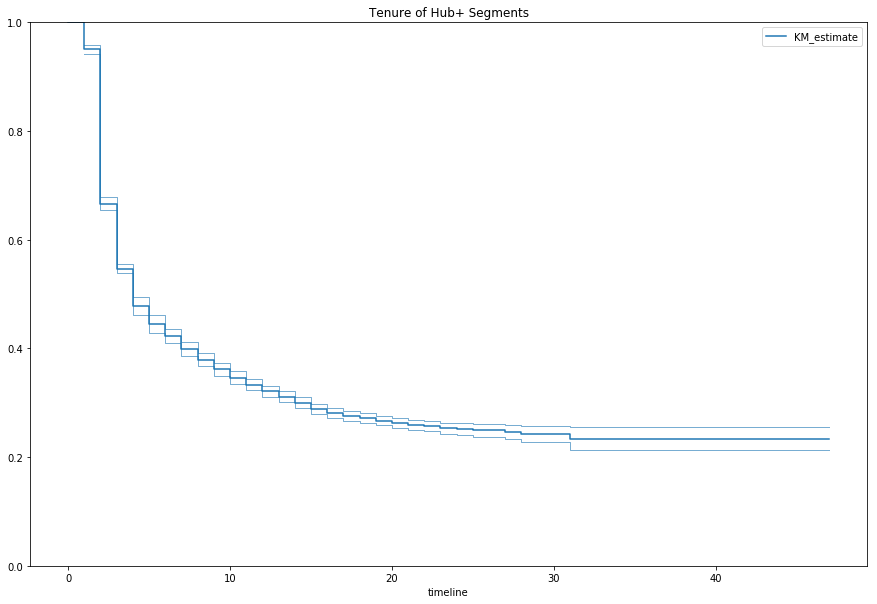

In [16]:
T = df_survival['tenure']
E = df_survival['churned']

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

plt.figure(figsize = (15,10))
ax = plt.subplot(111)

kmf.fit(T, event_observed = E)
kmf.plot(ax = ax, ci_force_lines = True)

plt.ylim(0, 1);
plt.title("Tenure of Hub+ Segments");

In [17]:
kmf.fit(T, event_observed = E)
kmf.median_

4.0

# Generate the Nelson-Aelen Curve for the Hub+ Data

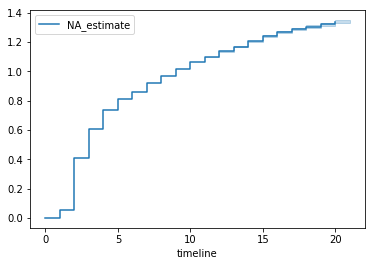

In [18]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T, event_observed=E)
ax = naf.plot(loc = slice(0, 20))